In [253]:
import numpy as np
from keras.engine.keras_tensor import KerasTensor
from tensorflow.keras.models import Model, load_model
from typing import List, Optional
from tensorflow import GradientTape, reduce_mean
from utils.audio_tools import create_audio_player
from utils.displays import display_mel_spectrogram
import tensorflow as tf
from matplotlib import pyplot as plt
from librosa.display import specshow
from librosa import power_to_db
from librosa.feature.inverse import mel_to_audio
from soundfile import write
import utils.constants as consts
from os.path import join
import os
from librosa.feature import melspectrogram
from librosa import tone
from librosa import load
from utils.audio_tools import segment_signal


PATH_TO_MODEL: str = '../runs/models/model_3/epoch-96.pb'
PATH_TO_AUDIO: str = '../media/audio/string_a#.wav'
NUM_LAYERS: int = 44

Get indices of Conv block layers.

In [254]:
model: Model = load_model(PATH_TO_MODEL)
layer_output: List[KerasTensor] = [layer.output for layer in model.layers[:NUM_LAYERS]]
activation_model = Model(inputs=model.input, outputs=layer_output)

layers: List[Model] = activation_model.layers
conv_block_indicis: List[int] = []

for i, layer in enumerate(layers):
    if 'conv' in layer.name:
        conv_block_indicis.append(i)

In [255]:
def compute_loss(
        _feature_extractor: Model,
        input_image: np.ndarray,
        _filter_index: int
) -> float:
    """
    :param _feature_extractor:
    :param input_image:
    :param _filter_index:
    :return:
    """

    activation: List[np.ndarray] = _feature_extractor(input_image)

    # We avoid border artifacts by only involving non-border pixels in the loss.
    filter_activation = activation[:, 2: -2, 2: -2, _filter_index]

    return reduce_mean(filter_activation)

In [256]:
@tf.function
def gradient_ascent_step(
        _feature_extractor: Model,
        image: np.ndarray,
        _filter_index: int,
        learning_rate: float
) -> np.ndarray:
    """
    :param _feature_extractor:
    :param image:
    :param _filter_index:
    :param learning_rate:
    :return:
    """

    with GradientTape() as tape:
        tape.watch(image)
        _loss = compute_loss(_feature_extractor, image, _filter_index)

    # Compute gradients.
    grads = tape.gradient(_loss, image)

    # Normalize gradients.
    grads = tf.math.l2_normalize(grads)
    image += learning_rate * grads

    return image

In [257]:
def initialize_image() -> np.ndarray:
    """
    :return:
    """

    # We start from a gray image with some random noise.
    image: np.ndarray = tf.random.uniform((1, 300, 44, 1))

    return image


def visualize_filter(
        _feature_extractor: Model,
        _filter_index: int,
        learning_rate: float = 10.0,
        iterations: int = 30,
        _signal: Optional[np.ndarray] = None
) -> np.ndarray:
    """
    :param _feature_extractor:
    :param _filter_index:
    :param learning_rate:
    :param iterations:
    :param _signal:
    :return:
    """

    if signal is None:
        _signal: np.ndarray = initialize_image()

    for iteration in range(iterations):
        _signal: np.ndarray = gradient_ascent_step(
            _feature_extractor,
            _signal,
            _filter_index,
            learning_rate
        )

    # Decode the resulting input image.
    image: np.ndarray = deprocess_image(_signal[0].numpy())

    return image


def deprocess_image(image: np.ndarray) -> np.ndarray:
    """
    :param image:
    :return:
    """

    # Normalize array: center on 0., ensure variance is 0.15.
    # image -= image.mean()
    # image /= image.std() + 1e-5
    # image *= 0.15

    # Center crop.
    # image = image[25 : -25, 25: -25, :]

    # Clip to [0, 1].
    image = np.clip(image, 0, 1)

    return image

In [258]:
# Set up a model that returns the activation values for our target layer.
layer: Model = model.get_layer(name=layers[conv_block_indicis[0]].name)
feature_extractor: Model = Model(inputs=model.inputs, outputs=layer.output)

In [259]:
PATH_TO_GUITAR: str = '../long-audio/break_2.wav'
guitar_sample: np.ndarray = load(PATH_TO_GUITAR)[0]

create_audio_player(guitar_sample)

In [260]:
guitar_sample_segmented: List[np.ndarray] = segment_signal(guitar_sample, window_leap_fraction=1)

create_audio_player(guitar_sample_segmented[0])

In [261]:
guitar_mels: List[np.ndarray] = []

for sample in guitar_sample_segmented:
    encoded_guitar: np.ndarray = melspectrogram(
        y=sample,
        sr=consts.SAMPLE_RATE,
        n_fft=consts.NUM_FFT,
        hop_length=consts.MEL_HOP_LEN,
        n_mels=consts.NUM_MELS,
        win_length=consts.MEL_WINDOW_LEN
    )

    encoded_guitar = np.array([encoded_guitar.reshape(consts.X_SHAPE)])

    guitar_mels.append(encoded_guitar)

create_audio_player(guitar_mels[2])

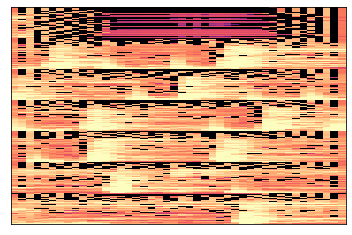

In [262]:
OUTPUT_DIR: str = '../feature_visualization'

os.makedirs(OUTPUT_DIR, exist_ok=True)
os.makedirs(join(OUTPUT_DIR, 'mel_specs'), exist_ok=True)

# for i in range(layer.output.shape[-1] - 1):
# for i in range(5):
# i: int = 17

for neuron_i in range(layer.output.shape[-1] - 1):
    mel_specs: List[np.ndarray] = []
    processed_signal: List[np.ndarray] = []

    for mel in guitar_mels:
        neuron_feature: np.ndarray = visualize_filter(
            feature_extractor,
            neuron_i,
            learning_rate=1,
            iterations=5,
            _signal=mel
        )

        neuron_feature = neuron_feature.reshape(300, 44)

        signal: np.ndarray = mel_to_audio(
            neuron_feature,
            sr=consts.SAMPLE_RATE,
            n_iter=consts.MEL_TO_AUDIO_N_ITERATIONS
        )

        processed_signal.append(signal)
        mel_specs.append(neuron_feature)

    final_signal: np.ndarray = np.stack(processed_signal)
    final_signal = np.concatenate(final_signal)
    neuron_name: str = f'neuron_{neuron_i}'

    mel_specs_concate: np.ndarray = np.concatenate(np.stack(mel_specs))
    mel_spec_log: np.ndarray = power_to_db(mel_specs_concate, ref=np.max)

    specshow(mel_spec_log, sr=consts.SAMPLE_RATE)
    plt.savefig(join(OUTPUT_DIR, 'mel_specs', neuron_name + '.png'))
    write(join(OUTPUT_DIR, neuron_name) + '.wav', final_signal, samplerate=consts.SAMPLE_RATE)

# display_mel_spectrogram(neuron_feature)
# create_audio_player(signal, normalize=True)

In [263]:
# final_signal: np.ndarray = np.stack(processed_signal)
# final_signal = np.concatenate(final_signal)
# create_audio_player(final_signal)

In [264]:
sine_wave: np.ndarray = tone(440, duration=1, sr=consts.SAMPLE_RATE)

encoded_sine_wave: np.ndarray = melspectrogram(
    y=sine_wave,
    sr=consts.SAMPLE_RATE,
    n_fft=consts.NUM_FFT,
    hop_length=consts.MEL_HOP_LEN,
    n_mels=consts.NUM_MELS,
    win_length=consts.MEL_WINDOW_LEN
)

encoded_sine_wave = np.array([encoded_sine_wave.reshape(consts.X_SHAPE)])

create_audio_player(encoded_sine_wave, normalize=True)